In [113]:
import numpy as np
import pandas as pd
from patsy import dmatrix

In [114]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [115]:
# weather 파일 불러오기
wthr = pd.read_csv("weather.csv")
wthr.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


In [116]:
wthr = wthr.replace("M", np.nan)
wthr = wthr.replace("-", np.nan)
wthr["snowfall"] = wthr["snowfall"].replace("  T", 0.05)
wthr["preciptotal"] = wthr["preciptotal"].replace("  T", 0.005)
wthr.to_csv("weather_rem.csv", sep=",", index=False)

---

In [117]:
wthr = pd.read_csv("weather_rem.csv")

In [118]:
len(wthr)

20517

In [119]:
# tavg 변수 채우기
wthr["tavg"] = round((wthr["tmin"] + wthr["tmax"])/2+0.5, 0)

In [120]:
# codesum변수 만들기 nothing, rain, other
wthr['codesum'].replace("+", "")
a = []
for i in range(len(wthr['codesum'])):
    a.append(wthr.loc[i, 'codesum'].split(" "))
    for i_text in a[i]:
        if len(i_text) == 4:
            a[i].append(i_text[:2])
            a[i].append(i_text[2:])

In [121]:
rain_text = ['FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'IC', 'FG', 'BR', 'UP', 'FG+']
other_text = ['HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC' ]
wthr["nothing"] = 1
wthr["rain"] = 0
wthr["other"] = 0
b = -1
for ls in a:
    b += 1
    for text in ls:
        if text in rain_text:
            wthr.loc[b, 'rain'] = 1
            wthr.loc[b, 'nothing'] = 0
        elif text in other_text:
            wthr.loc[b,'other'] = 1
            wthr.loc[b, 'nothing'] = 0 

In [122]:
# 날짜데이터 datetime 변환
wthr["date"] = pd.to_datetime(wthr["date"])

In [123]:
# date 년, 월, 일 columns 추가하기
wthr["date_y"] = wthr["date"].dt.year
wthr["date_m"] = wthr["date"].dt.month
wthr["date_d"] = wthr["date"].dt.day

# 요일 columns 추가(monday = 0, sunday = 6), 주말 columns 추가
wthr["week7"] = wthr["date"].dt.dayofweek
wthr['weekend'] = 0
wthr.loc[wthr['week7'] == 5, 'weekend'] = 1
wthr.loc[wthr['week7'] == 6, 'weekend'] = 1

In [124]:
# 상대습도 계산
wthr["relative_humility"] = 100*(np.exp((17.625*((wthr['dewpoint']-32)/1.8))/(243.04+((wthr['dewpoint']-32)/1.8)))/np.exp((17.625*((wthr['tavg']-32)/1.8))/(243.04+((wthr['tavg']-32)/1.8))))

In [125]:
# 체감온도 계산
wthr["windchill"] = 35.74 + 0.6215*wthr["tavg"] - 35.75*(wthr["avgspeed"]**0.16) + 0.4275*wthr["tavg"]*(wthr["avgspeed"]**0.16)

In [126]:
# sunset, sunrise 단위를 분으로 고치기
wthr["sunrise"] = ((wthr["sunrise"]// 100 * 60) + (wthr['sunrise'] % 100))
wthr["sunset"] = ((wthr['sunset'] // 100 * 60) + (wthr['sunset'] % 100))

In [127]:
# daytime 계산
wthr["daytime"] = wthr["sunset"] - wthr["sunrise"]

In [128]:
len(wthr)

20517

In [129]:
# holiday 변수
def getHolidayDates(filepath):

    HolidaysFile = open(filepath)
    lines = HolidaysFile.readlines()
    lines = [line.split(" ")[:3] for line in lines]
    lines = ["{} {} {}".format(line[0], line[1], line[2]) for line in lines]
    lines = pd.to_datetime(lines)
    return pd.DataFrame({"date": lines})

holidays = getHolidayDates('holidays.txt')
holidays["holiday"] = 1

In [130]:
wthr = wthr.merge(holidays, how="outer", on="date")

In [131]:
len(wthr)

20522

In [132]:
wthr["holiday"] = wthr["holiday"].fillna(0)
wthr["station_nbr"] = wthr["station_nbr"].fillna(0)
wthr = wthr[wthr["station_nbr"] != 0]

In [133]:
len(wthr)

20517

In [134]:
wthr.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,nothing,rain,other,date_y,date_m,date_d,week7,weekend,relative_humility,windchill,daytime,holiday
20512,16.0,2014-10-31,53.0,34.0,44.0,NaN,35.0,41.0,21.0,0.0,NaN,NaN,,NaN,0.00,29.90,29.99,4.5,3.0,5.3,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,70.432849,40.965367,NaN,1.0
20513,17.0,2014-10-31,59.0,34.0,47.0,NaN,32.0,41.0,18.0,0.0,NaN,NaN,RA,0.0,0.00,29.72,30.39,9.2,1.0,9.3,0.0,1.0,0.0,2014.0,10.0,31.0,4.0,0.0,55.750138,42.579794,NaN,1.0
20514,18.0,2014-10-31,67.0,49.0,58.0,-4.0,40.0,50.0,7.0,0.0,404.0,1058.0,,0.0,0.00,29.78,30.28,10.6,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,51.057657,55.662463,654.0,1.0
20515,19.0,2014-10-31,45.0,33.0,40.0,-6.0,24.0,32.0,26.0,0.0,384.0,1006.0,RA SN,0.1,0.02,29.51,30.24,20.4,34.0,20.9,0.0,1.0,0.0,2014.0,10.0,31.0,4.0,0.0,52.475262,30.267917,622.0,1.0
20516,20.0,2014-10-31,68.0,50.0,60.0,NaN,39.0,50.0,6.0,0.0,NaN,NaN,,0.0,0.00,29.57,30.27,10.5,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,45.719851,58.163927,NaN,1.0


In [135]:
wthr.to_csv("weather_adj.csv", sep=",", index=False)

---

In [136]:
wthr = pd.read_csv("weather_adj.csv")

In [137]:
train = pd.read_csv("train.csv")
train.tail()

,date,store_nbr,item_nbr,units
4617595,2014-10-31,45,107,0
4617596,2014-10-31,45,108,0
4617597,2014-10-31,45,109,0
4617598,2014-10-31,45,110,0
4617599,2014-10-31,45,111,0


In [138]:
key = pd.read_csv("key.csv")
key.tail()

,store_nbr,station_nbr
40,41,12
41,42,14
42,43,11
43,44,12
44,45,16


In [139]:
# key와 train 합치기
key_train = pd.merge(key, train, on="store_nbr")

In [140]:
# key와 train csv파일 만들기
key_train.to_csv("key_train.csv", sep=",", index=False)

In [141]:
# 전체 merge
wthr_df = wthr.merge(key_train, on=("date", "station_nbr"))

In [142]:
wthr_df.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,nothing,rain,other,date_y,date_m,date_d,week7,weekend,relative_humility,windchill,daytime,holiday,store_nbr,item_nbr,units
4617595,20,2014-10-31,68.0,50.0,60.0,NaN,39.0,50.0,6.0,0.0,NaN,NaN,,0.0,0.0,29.57,30.27,10.5,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,45.719851,58.163927,NaN,1.0,17,107,0
4617596,20,2014-10-31,68.0,50.0,60.0,NaN,39.0,50.0,6.0,0.0,NaN,NaN,,0.0,0.0,29.57,30.27,10.5,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,45.719851,58.163927,NaN,1.0,17,108,0
4617597,20,2014-10-31,68.0,50.0,60.0,NaN,39.0,50.0,6.0,0.0,NaN,NaN,,0.0,0.0,29.57,30.27,10.5,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,45.719851,58.163927,NaN,1.0,17,109,0
4617598,20,2014-10-31,68.0,50.0,60.0,NaN,39.0,50.0,6.0,0.0,NaN,NaN,,0.0,0.0,29.57,30.27,10.5,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,45.719851,58.163927,NaN,1.0,17,110,0
4617599,20,2014-10-31,68.0,50.0,60.0,NaN,39.0,50.0,6.0,0.0,NaN,NaN,,0.0,0.0,29.57,30.27,10.5,36.0,11.2,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,45.719851,58.163927,NaN,1.0,17,111,0


In [143]:
wthr_df.to_csv("merge_total_raw.csv", sep=",", index=False)

---

---

In [3]:
total = pd.read_csv("merge_total_raw.csv")

In [5]:
total["preciptotal"].median()

0.0

In [284]:
# station으로 분리
w_stn_1 = wthr[wthr["station_nbr"] == 1]
w_stn_2 = wthr[wthr["station_nbr"] == 2]
w_stn_3 = wthr[wthr["station_nbr"] == 3]
w_stn_4 = wthr[wthr["station_nbr"] == 4]
w_stn_5 = wthr[wthr["station_nbr"] == 5]
w_stn_6 = wthr[wthr["station_nbr"] == 6]
w_stn_7 = wthr[wthr["station_nbr"] == 7]
w_stn_8 = wthr[wthr["station_nbr"] == 8]
w_stn_9 = wthr[wthr["station_nbr"] == 9]
w_stn_10 = wthr[wthr["station_nbr"] == 10]
w_stn_11 = wthr[wthr["station_nbr"] == 11]
w_stn_12 = wthr[wthr["station_nbr"] == 12]
w_stn_13 = wthr[wthr["station_nbr"] == 13]
w_stn_14 = wthr[wthr["station_nbr"] == 14]
w_stn_15 = wthr[wthr["station_nbr"] == 15]
w_stn_16 = wthr[wthr["station_nbr"] == 16]
w_stn_17 = wthr[wthr["station_nbr"] == 17]
w_stn_18 = wthr[wthr["station_nbr"] == 18]
w_stn_19 = wthr[wthr["station_nbr"] == 19]
w_stn_20 = wthr[wthr["station_nbr"] == 20]

In [285]:
# sunset, sunrise 채우기
ls = [2, 3, 4, 5, 6, 10, 11, 14, 15, 18, 19]
w_stn_2.loc[(w_stn_2["date_y"] == 2014) & (w_stn_2["date_m"] == 1), "sunrise"] = w_stn_2.loc[(w_stn_2["date_y"] == 2013)\
                                                                                             & (w_stn_2["date_m"] == 1), "sunrise"].values
w_stn_2.loc[(w_stn_2["date_y"] == 2014) & (w_stn_2["date_m"] == 1), "sunset"] = w_stn_2.loc[(w_stn_2["date_y"] == 2013)\
                                                                                             & (w_stn_2["date_m"] == 1), "sunset"].values
w_stn_3.loc[(w_stn_3["date_y"] == 2014) & (w_stn_3["date_m"] == 1), "sunrise"] = w_stn_3.loc[(w_stn_3["date_y"] == 2013)\
                                                                                             & (w_stn_3["date_m"] == 1), "sunrise"].values
w_stn_3.loc[(w_stn_3["date_y"] == 2014) & (w_stn_3["date_m"] == 1), "sunset"] = w_stn_3.loc[(w_stn_3["date_y"] == 2013)\
                                                                                             & (w_stn_3["date_m"] == 1), "sunset"].values
w_stn_4.loc[(w_stn_4["date_y"] == 2014) & (w_stn_4["date_m"] == 1), "sunrise"] = w_stn_4.loc[(w_stn_4["date_y"] == 2013)\
                                                                                             & (w_stn_4["date_m"] == 1), "sunrise"].values
w_stn_4.loc[(w_stn_4["date_y"] == 2014) & (w_stn_4["date_m"] == 1), "sunset"] = w_stn_4.loc[(w_stn_4["date_y"] == 2013)\
                                                                                             & (w_stn_4["date_m"] == 1), "sunset"].values
w_stn_5.loc[(w_stn_5["date_y"] == 2014) & (w_stn_5["date_m"] == 1), "sunrise"] = w_stn_5.loc[(w_stn_5["date_y"] == 2013)\
                                                                                             & (w_stn_5["date_m"] == 1), "sunrise"].values
w_stn_5.loc[(w_stn_5["date_y"] == 2014) & (w_stn_5["date_m"] == 1), "sunset"] = w_stn_5.loc[(w_stn_5["date_y"] == 2013)\
                                                                                             & (w_stn_5["date_m"] == 1), "sunset"].values
w_stn_6.loc[(w_stn_6["date_y"] == 2014) & (w_stn_6["date_m"] == 1), "sunrise"] = w_stn_6.loc[(w_stn_6["date_y"] == 2013)\
                                                                                             & (w_stn_6["date_m"] == 1), "sunrise"].values
w_stn_6.loc[(w_stn_6["date_y"] == 2014) & (w_stn_6["date_m"] == 1), "sunset"] = w_stn_6.loc[(w_stn_6["date_y"] == 2013)\
                                                                                             & (w_stn_6["date_m"] == 1), "sunset"].values
w_stn_10.loc[(w_stn_10["date_y"] == 2014) & (w_stn_10["date_m"] == 1), "sunrise"] = w_stn_10.loc[(w_stn_10["date_y"] == 2013)\
                                                                                             & (w_stn_10["date_m"] == 1), "sunrise"].values
w_stn_10.loc[(w_stn_10["date_y"] == 2014) & (w_stn_10["date_m"] == 1), "sunset"] = w_stn_10.loc[(w_stn_10["date_y"] == 2013)\
                                                                                             & (w_stn_10["date_m"] == 1), "sunset"].values
w_stn_11.loc[(w_stn_11["date_y"] == 2014) & (w_stn_11["date_m"] == 1), "sunrise"] = w_stn_11.loc[(w_stn_11["date_y"] == 2013)\
                                                                                             & (w_stn_11["date_m"] == 1), "sunrise"].values
w_stn_11.loc[(w_stn_11["date_y"] == 2014) & (w_stn_11["date_m"] == 1), "sunset"] = w_stn_11.loc[(w_stn_11["date_y"] == 2013)\
                                                                                             & (w_stn_11["date_m"] == 1), "sunset"].values
w_stn_14.loc[(w_stn_14["date_y"] == 2014) & (w_stn_14["date_m"] == 1), "sunrise"] = w_stn_14.loc[(w_stn_14["date_y"] == 2013)\
                                                                                             & (w_stn_14["date_m"] == 1), "sunrise"].values
w_stn_14.loc[(w_stn_14["date_y"] == 2014) & (w_stn_14["date_m"] == 1), "sunset"] = w_stn_14.loc[(w_stn_14["date_y"] == 2013)\
                                                                                             & (w_stn_14["date_m"] == 1), "sunset"].values
w_stn_15.loc[(w_stn_15["date_y"] == 2014) & (w_stn_15["date_m"] == 1), "sunrise"] = w_stn_15.loc[(w_stn_15["date_y"] == 2013)\
                                                                                             & (w_stn_15["date_m"] == 1), "sunrise"].values
w_stn_15.loc[(w_stn_15["date_y"] == 2014) & (w_stn_15["date_m"] == 1), "sunset"] = w_stn_15.loc[(w_stn_15["date_y"] == 2013)\
                                                                                             & (w_stn_15["date_m"] == 1), "sunset"].values
w_stn_18.loc[(w_stn_18["date_y"] == 2014) & (w_stn_18["date_m"] == 1), "sunrise"] = w_stn_18.loc[(w_stn_18["date_y"] == 2013)\
                                                                                             & (w_stn_18["date_m"] == 1), "sunrise"].values
w_stn_18.loc[(w_stn_18["date_y"] == 2014) & (w_stn_18["date_m"] == 1), "sunset"] = w_stn_18.loc[(w_stn_18["date_y"] == 2013)\
                                                                                             & (w_stn_18["date_m"] == 1), "sunset"].values
w_stn_19.loc[(w_stn_19["date_y"] == 2014) & (w_stn_19["date_m"] == 1), "sunrise"] = w_stn_19.loc[(w_stn_19["date_y"] == 2013)\
                                                                                             & (w_stn_19["date_m"] == 1), "sunrise"].values
w_stn_19.loc[(w_stn_19["date_y"] == 2014) & (w_stn_19["date_m"] == 1), "sunset"] = w_stn_19.loc[(w_stn_19["date_y"] == 2013)\
                                                                                             & (w_stn_19["date_m"] == 1), "sunset"].values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [286]:
w_stn_1.tail()

,station_nbr,date,tmax,tmin,tavg,tavg_r,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,nothing,rain,other,date_y,date_m,date_d,week7,weekend,relative_humility,windchill,daytime,tavg-dew,holiday
20417,1.0,2014-10-27,61.0,41.0,51.0,51.0,NaN,38.0,44.0,14.0,0.0,NaN,NaN,,NaN,0.00,29.70,29.89,6.3,27.0,7.3,1.0,0.0,0.0,2014.0,10.0,27.0,0.0,0.0,60.947558,48.266239,NaN,13.0,0.0
20437,1.0,2014-10-28,65.0,37.0,51.0,51.0,NaN,45.0,48.0,14.0,0.0,NaN,NaN,BR,NaN,0.00,29.86,30.02,1.4,9.0,3.6,0.0,1.0,0.0,2014.0,10.0,28.0,1.0,0.0,79.853021,50.316460,NaN,6.0,0.0
20457,1.0,2014-10-29,66.0,48.0,57.0,57.0,NaN,51.0,53.0,8.0,0.0,NaN,NaN,RA FG+ FG BR,NaN,0.11,29.70,29.86,2.9,27.0,4.4,0.0,1.0,0.0,2014.0,10.0,29.0,2.0,0.0,80.320545,56.738033,NaN,6.0,0.0
20477,1.0,2014-10-30,57.0,39.0,48.0,48.0,NaN,39.0,43.0,17.0,0.0,NaN,NaN,,NaN,0.00,29.78,29.95,2.1,28.0,3.7,1.0,0.0,0.0,2014.0,10.0,30.0,3.0,0.0,70.872191,46.795606,NaN,9.0,0.0
20497,1.0,2014-10-31,53.0,40.0,47.0,47.0,NaN,36.0,41.0,18.0,0.0,NaN,NaN,,NaN,0.00,29.87,30.03,5.4,4.0,5.8,1.0,0.0,0.0,2014.0,10.0,31.0,4.0,0.0,65.403313,44.207532,NaN,11.0,1.0


In [287]:
stn_1 = w_stn_1.merge(key_train)

In [56]:
stn_1

,station_nbr,date,tmax,tmin,tavg,tavg_r,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,date_y,date_m,date_d,week7,weekend,relative_humility,windchill,daytime,tavg-dew,store_nbr,item_nbr,units


In [3]:
r = pd.read_csv("key_train.csv")

In [5]:
r.corr()

,store_nbr,station_nbr,item_nbr,units
store_nbr,1.000000e+00,2.199581e-01,-1.401315e-17,-0.003277
station_nbr,2.199581e-01,1.000000e+00,-4.222414e-18,0.001433
item_nbr,-1.401315e-17,-4.222414e-18,1.000000e+00,-0.085440
units,-3.276535e-03,1.433469e-03,-8.544025e-02,1.000000


In [6]:
%matplotlib inline

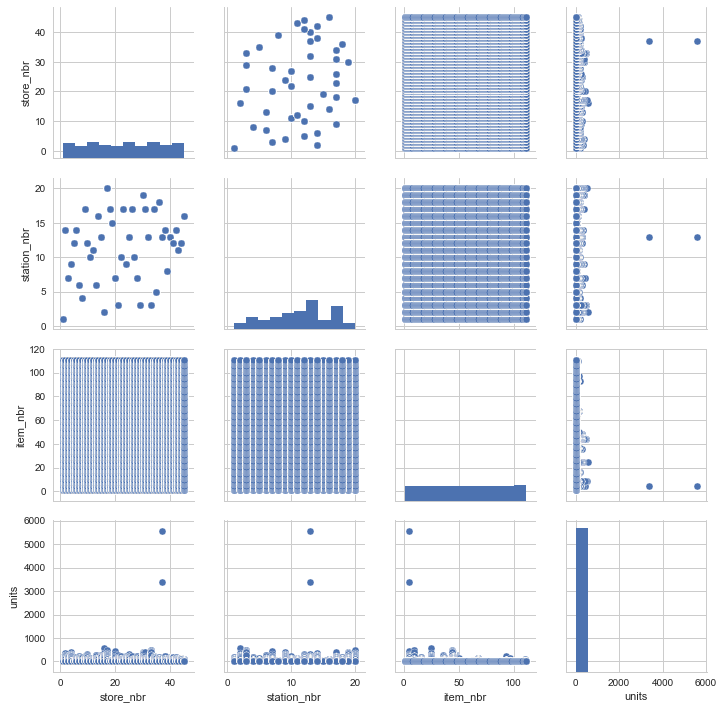

In [7]:
sns.pairplot(r)

In [116]:
a = pd.DataFrame(ls8).T
w_stn_8_itp = w_stn_8.copy()
w_stn_8_itp.update(a)
w_stn_8_itp.describe()

,station_nbr,tmax,tmin,tavg,tavg_r,depart,dewpoint,wetbulb,heat,cool,...,date_m,date_d,doweek,weekend,rel_hum,windchill,week7,relative_humility,daytime,tavg-dew
count,1035.0,1035.000000,1035.000000,1035.000000,567.000000,0.0,1035.000000,1035.000000,1021.000000,1000.000000,...,1035.000000,1035.000000,1035.000000,1035.000000,979.000000,1020.000000,1035.000000,979.000000,0.0,979.000000
mean,8.0,81.696618,60.512560,71.347343,73.268078,NaN,58.920290,63.613527,3.473066,9.777000,...,6.228019,15.731401,2.998068,0.285024,65.970655,73.259945,2.998068,65.970655,NaN,12.327886
std,0.0,14.105699,14.388193,13.816150,14.387449,NaN,14.706532,12.666566,6.765143,8.884267,...,3.322770,8.805294,2.000966,0.451644,11.380461,16.265676,2.000966,11.380461,NaN,5.003654
min,8.0,33.000000,19.000000,31.000000,31.000000,NaN,8.000000,25.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,18.285631,22.278129,0.000000,18.285631,NaN,0.000000
25%,8.0,73.000000,50.000000,61.000000,65.000000,NaN,49.000000,55.000000,0.000000,0.000000,...,3.000000,8.000000,1.000000,0.000000,59.622269,61.564365,1.000000,59.622269,NaN,9.000000
50%,8.0,84.000000,64.000000,74.000000,77.000000,NaN,63.000000,67.000000,0.000000,9.000000,...,6.000000,16.000000,3.000000,0.000000,66.063649,76.152270,3.000000,66.063649,NaN,12.000000
75%,8.0,92.000000,73.000000,83.000000,85.000000,NaN,71.000000,75.000000,4.000000,18.000000,...,9.000000,23.000000,5.000000,1.000000,73.423447,86.988609,5.000000,73.423447,NaN,15.000000
max,8.0,109.000000,81.000000,93.000000,93.000000,NaN,77.000000,80.000000,34.000000,28.000000,...,12.000000,31.000000,6.000000,1.000000,100.000000,99.359560,6.000000,100.000000,NaN,46.000000


In [ ]:
dic4[itp] = values

In [128]:
class he():
    def setData(self, obj):
        self.obj = obj
        self.itp = obj+"_itp"
        return self.obj, self.itp
    
    def interPolation(self):
        a = self.obj[wthr_itp].interpolate(limit_direction="both")
        self.itp = self.obj.copy()
        self.itp.update(a)
        return self.itp
    

In [129]:
a = he()

In [130]:
a.setData("w_stn_8")

('w_stn_8', 'w_stn_8_itp')

In [140]:
def name():
    for i in range(5):
        "qwe"
    

In [141]:
for i in range(3):
    name() + str(i)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [6]:
a = 1

In [13]:
def MyClass():
    return a

In [16]:
objs = [MyClass() for i in range(10)]

objs[0]

1

In [18]:
a= {'q':[2, 3], 'e':[23]}

In [19]:
b = {'q':}

{'e': [23], 'q': [2, 3]}

In [25]:
# interpolation 한 것으로 치환
w_stn_4_itp = w_stn_4.copy()
dic4 = {}
for itp, values in zip(wthr_itp, ls4):
    dic4[itp] = values
w_stn_4_itp.update(pd.DataFrame(dic4))

In [54]:
# interpolation 한 것으로 치환
w_stn_8_itp = w_stn_8.copy()
dic8 = {}
for itp, values in zip(wthr_itp, ls8):
    dic8[itp] = values
w_stn_8_itp.update(pd.DataFrame(dic8))

In [55]:
w_stn_8_itp.describe()

,station_nbr,tmax,tmin,tavg,tavg_r,depart,dewpoint,wetbulb,heat,cool,...,date_m,date_d,doweek,weekend,rel_hum,windchill,week7,relative_humility,daytime,tavg-dew
count,1035.0,1035.000000,1035.000000,1035.000000,567.000000,0.0,1035.000000,1035.000000,1021.000000,1000.000000,...,1035.000000,1035.000000,1035.000000,1035.000000,979.000000,1020.000000,1035.000000,979.000000,0.0,979.000000
mean,8.0,81.696618,60.512560,71.347343,73.268078,NaN,58.920290,63.613527,3.473066,9.777000,...,6.228019,15.731401,2.998068,0.285024,65.970655,73.259945,2.998068,65.970655,NaN,12.327886
std,0.0,14.105699,14.388193,13.816150,14.387449,NaN,14.706532,12.666566,6.765143,8.884267,...,3.322770,8.805294,2.000966,0.451644,11.380461,16.265676,2.000966,11.380461,NaN,5.003654
min,8.0,33.000000,19.000000,31.000000,31.000000,NaN,8.000000,25.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,18.285631,22.278129,0.000000,18.285631,NaN,0.000000
25%,8.0,73.000000,50.000000,61.000000,65.000000,NaN,49.000000,55.000000,0.000000,0.000000,...,3.000000,8.000000,1.000000,0.000000,59.622269,61.564365,1.000000,59.622269,NaN,9.000000
50%,8.0,84.000000,64.000000,74.000000,77.000000,NaN,63.000000,67.000000,0.000000,9.000000,...,6.000000,16.000000,3.000000,0.000000,66.063649,76.152270,3.000000,66.063649,NaN,12.000000
75%,8.0,92.000000,73.000000,83.000000,85.000000,NaN,71.000000,75.000000,4.000000,18.000000,...,9.000000,23.000000,5.000000,1.000000,73.423447,86.988609,5.000000,73.423447,NaN,15.000000
max,8.0,109.000000,81.000000,93.000000,93.000000,NaN,77.000000,80.000000,34.000000,28.000000,...,12.000000,31.000000,6.000000,1.000000,100.000000,99.359560,6.000000,100.000000,NaN,46.000000


In [57]:
w_stn_8['tavg'].mean(), w_stn_8_itp['tavg'].mean()

(71.26274509803922, 71.34734299516909)

In [58]:
w_stn_8['tavg'].var(), w_stn_8_itp['tavg'].var()

(190.60018087706095, 190.88599255739615)

In [63]:
# 등분산 검정
sp.stats.bartlett(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

BartlettResult(statistic=0.000575870912754599, pvalue=0.9808547539753195)

In [64]:
sp.stats.fligner(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

FlignerResult(statistic=0.0010324161021862612, pvalue=0.9743673963273202)

In [65]:
sp.stats.levene(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

LeveneResult(statistic=0.0006738670248349069, pvalue=0.979292604375982)

In [66]:
# two-sample t-test
sp.stats.ttest_ind(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'], equal_var=True)

Ttest_indResult(statistic=-0.13883479509595156, pvalue=0.8895943143209109)

In [67]:
# 정규성 검정
sp.stats.ks_2samp(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

Ks_2sampResult(statistic=0.00593918726911058, pvalue=1.0000000000000002)

In [68]:
sp.stats.mstats.normaltest(w_stn_8_itp['tavg'])

NormaltestResult(statistic=78.2562795755462, pvalue=1.0159323813231334e-17)

In [69]:
# 등분산 검정
sp.stats.bartlett(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

BartlettResult(statistic=0.000575870912754599, pvalue=0.9808547539753195)

In [71]:
sp.stats.fligner(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

FlignerResult(statistic=0.0010324161021862612, pvalue=0.9743673963273202)

In [72]:
sp.stats.levene(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

LeveneResult(statistic=0.0006738670248349069, pvalue=0.979292604375982)

In [73]:
# two-sample t-test
sp.stats.ttest_ind(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'], equal_var=True)

Ttest_indResult(statistic=-0.13883479509595156, pvalue=0.8895943143209109)

In [74]:
# 정규성 검정
sp.stats.ks_2samp(w_stn_8['tavg'].dropna(), w_stn_8_itp['tavg'])

Ks_2sampResult(statistic=0.00593918726911058, pvalue=1.0000000000000002)

In [76]:
for i in 
sp.stats.mstats.normaltest(w_stn_8_itp['tavg'])

NormaltestResult(statistic=78.2562795755462, pvalue=1.0159323813231334e-17)

In [92]:
# 정규성 검정
sp.stats.ks_2samp(w_stn_5['tavg'].dropna(), w_stn_3['tavg'].dropna())

Ks_2sampResult(statistic=0.2866731203614069, pvalue=0.012894289242984016)

In [102]:
sp.stats.ks_2samp(w_stn_5['tavg'].dropna(), w_stn_14['tavg'].dropna())

Ks_2sampResult(statistic=0.29151339141658605, pvalue=0.010859214691274894)

In [130]:
sp.stats.ks_2samp(w_stn_5['tavg'].dropna(), w_stn_17['tavg'].dropna())

Ks_2sampResult(statistic=0.28581560283687946, pvalue=0.01328696049769816)

In [ ]:
%matplotlib inline

In [126]:
def elim_na(obj, *args):
    a = obj[list(args)].dropna()
    return a